In [42]:
from functools import partial
import os
import torch
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.logger import get_logger
import numpy as np
from skimage.io import imsave
import warnings
warnings.filterwarnings('ignore')
from util.utils import image_read,load_yaml,norm_img,tensor_to_numpy
from guided_diffusion.unet import create_model,create_model_ir
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


In [43]:
model_config = load_yaml('configs/vi_model_config_imagenet.yaml')  
ir_model_config = load_yaml('configs/ir_model_config_imagenet.yaml') 
diffusion_config = load_yaml('configs/diffusion_config.yaml')

logger = get_logger()
device = "cuda:1"
input_path="./input"     
out_path = f'./output2/{diffusion_config["sampler"]}'

# Working directory
os.makedirs(out_path, exist_ok=True)
os.makedirs(os.path.join(out_path, 'recon'), exist_ok=True)
os.makedirs(os.path.join(out_path, 'progress'), exist_ok=True)

img_name = "FLIR_03952.jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 288, 512])
(288, 512, 3)


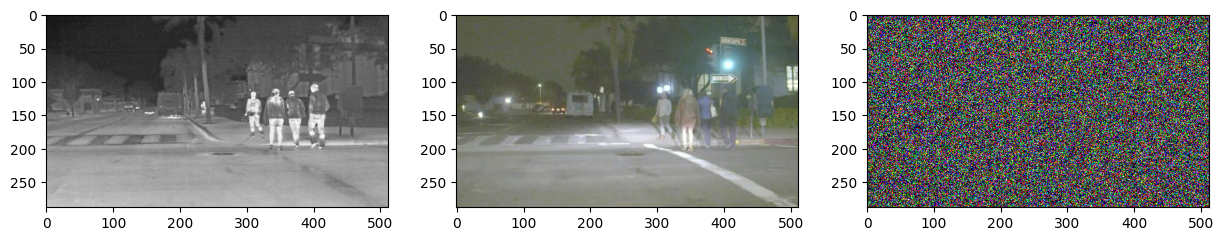

In [44]:
mode = 'RGB' #RGB:[1,1,H,W,3] GRAY:[1,1,H,W]

ir_img = image_read(os.path.join(os.path.join(input_path,"ir"), img_name),mode=mode)[np.newaxis,np.newaxis, ...]/255.0 
vi_img = image_read(os.path.join(os.path.join(input_path,"vi"),img_name), mode=mode)[np.newaxis,np.newaxis, ...]/255.0 
if mode == "RGB":
    #  (B, H, W, C)
    ir_img = np.squeeze(ir_img, axis=1)  
    vi_img = np.squeeze(vi_img, axis=1) 
    #  (B, C, H, W)
    ir_img = np.transpose(ir_img, (0, 3, 1, 2))  
    vi_img = np.transpose(vi_img, (0, 3, 1, 2)) 
 
# crop to make divisible
scale = 32
h, w = ir_img.shape[2:]
h = h - h % scale
w = w - w % scale

ir_img = ((torch.FloatTensor(ir_img))[:,:,:h,:w]).to(device)
vi_img = ((torch.FloatTensor(vi_img))[:,:,:h,:w]).to(device)

assert ir_img.shape == vi_img.shape

if mode == "RGB":# (1, 3, H, W)
    x_start = torch.randn(ir_img.shape, device=device)  
elif mode == "GRAY":# (1, 1, H, W)
    # x_start = torch.randn((ir_img.repeat(1, 3, 1, 1)).shape, device=device)  
    x_start = torch.randn_like(ir_img, device=device)



# Sampling
seed = 3407
torch.manual_seed(seed)

print(ir_img.shape)# torch.Size([1, 3, 288, 480]) / torch.Size([1, 1, 288, 480])
if mode == "RGB":
    inf_np = tensor_to_numpy(ir_img.squeeze().permute(1, 2, 0)) # 
    vis_np = tensor_to_numpy(vi_img.squeeze().permute(1, 2, 0))
    x_np = tensor_to_numpy(x_start.squeeze().permute(1, 2, 0))
else:
    ir_img = ir_img*2-1
    vi_img = vi_img*2-1
    x_start = x_start*2-1
    inf_np = tensor_to_numpy(ir_img.squeeze(0).squeeze(0).permute(0,1).unsqueeze(-1))
    vis_np = tensor_to_numpy(vi_img.squeeze(0).squeeze(0).permute(0,1).unsqueeze(-1))
    x_np = tensor_to_numpy(x_start.squeeze(0).squeeze(0).permute(0,1).unsqueeze(-1))

print(inf_np.shape)# (288, 480, 3)
# 创建子图
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
if mode == "RGB":
    # 显示原始RGB图像
    axs[0].imshow(inf_np)
    axs[1].imshow(vis_np)
    axs[2].imshow(x_np)
else:
    axs[0].imshow(inf_np, cmap='gray')
    axs[1].imshow(vis_np, cmap='gray')
    axs[2].imshow(x_np, cmap='gray')
# 显示图像
plt.show()

In [45]:
# Load model
model = create_model(**model_config)
model = model.to(device)
model.eval()
ir_model = create_model_ir(**ir_model_config)  
ir_model = ir_model.to(device)
ir_model.eval()
print("ok")

ok


In [46]:

# 根据 diffusion_config.sampler 参数来选择sampler
sampler = create_sampler(**diffusion_config) 
sample_fn = partial(sampler.p_sample_loop, model=model, ir_model = ir_model)

sampler = ddim


In [47]:
print(ir_img.shape) # torch.Size([1, 1, h, w])
with torch.no_grad(): # rho=0.001
    sample = sample_fn(x_start=x_start, 
                        record=True, 
                        I = ir_img, 
                        V = vi_img, 
                        save_root=out_path, 
                        img_index = os.path.splitext(img_name)[0], 
                        lamb=0.5,
                        rho=0.1)
    


torch.Size([1, 3, 288, 512])


  0%|          | 0/100 [00:00<?, ?it/s]

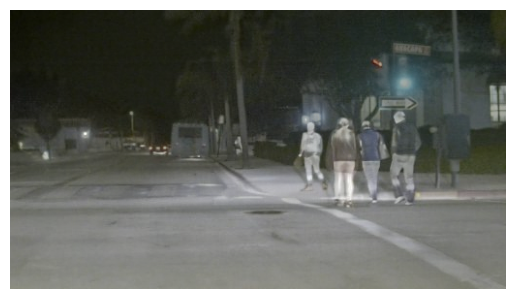

2024-08-05 10:28:30,356 [DPS] >> Save result in ./output2/ddim/recon
2024-08-05 10:28:30,356 [DPS] >> Save result in ./output2/ddim/recon
2024-08-05 10:28:30,356 [DPS] >> Save result in ./output2/ddim/recon
2024-08-05 10:28:30,356 [DPS] >> Save result in ./output2/ddim/recon
2024-08-05 10:28:30,356 [DPS] >> Save result in ./output2/ddim/recon


In [48]:
rgb_image = sample.squeeze().permute(1, 2, 0).cpu().numpy()
sample_norm=norm_img(rgb_image)
# 显示图像
plt.imshow(sample_norm)
plt.axis('off')  # 关闭坐标轴
plt.show()
save_path = os.path.join(out_path, 'recon')
save_name = "{}.png".format(img_name.split(".")[0])
imsave(os.path.join(save_path, save_name),sample_norm)
logger.info(f"Save result in {save_path}")
f_img_folder = "/home/2021/hexin/XJ2/D3FM/output2/d3fm_xt/recon"
vi_path = os.path.join(os.path.join(input_path,"vi"), img_name)
ir_path = os.path.join(os.path.join(input_path,"ir"), img_name)

In [49]:
from skimage.color import rgb2gray

# 移除所有尺寸为1的维度
vis_img = torch.squeeze(vi_img)
inf_img = torch.squeeze(ir_img)
sample = sample_norm
print(sample_norm.shape)
# 将张量转换为NumPy数组
inf_img = inf_img.permute(1, 2, 0).cpu().numpy() 
inf_img = (inf_img - np.min(inf_img)) / (np.max(inf_img) - np.min(inf_img)) # 归一化到0,1
vis_img = vis_img.permute(1, 2, 0).cpu().numpy() 
vis_img = (vis_img - np.min(vis_img)) / (np.max(vis_img) - np.min(vis_img)) # 归一化到0,1
sample = (sample - np.min(sample)) / (np.max(sample) - np.min(sample)) # 归一化到0,1
print(sample.shape)
print(inf_img.shape)
sample = rgb2gray(sample)
vis_img = rgb2gray(vis_img)
inf_img = rgb2gray(inf_img)

ssim_value1 = ssim(sample, vis_img, data_range=vis_img.max() - vis_img.min())
ssim_value2 = ssim(sample, inf_img, data_range=inf_img.max() - inf_img.min())

print(f"{img_name} {ssim_value1:.3f} {ssim_value2:.3f}")

(288, 512, 3)
(288, 512, 3)
(288, 512, 3)
FLIR_03952.jpg 0.760 0.806
